# Pipeline TE

In [1]:
import os
os.chdir('/home/clemens/armed_conflict_avalanche/')

from workspace.utils import *
from voronoi_globe.interface import load_voronoi
from arcolanche.pipeline import *
from arcolanche.transfer_entropy_func import *
#from arcolanche.network import *

#import matplotlib.pyplot as plt
#import cartopy.crs as ccrs

from utils_CB import get_coarsegrained, plot_cells

# Data, subset

In [2]:
conflict_type = "battles"
mesoscale = (32,453,3) #(dt, dx, gridix)
coarse = (32, 80, 3)

dt, dx, gridix = mesoscale

#data
load_pickle(f"avalanches/{conflict_type}/gridix_{gridix}/te/conflict_ev_{str(dt)}_{str(dx)}.p")
count_ts = get_coarsegrained(conflict_type, scale = mesoscale, binary=True)
polygons = load_voronoi(dx, gridix) #dx=57/b=528km, gridix=3

FileNotFoundError: [Errno 2] No such file or directory: 'avalanches/battles/gridix_3/te/conflict_ev_32_453.p'

Subset of dataset is used: Construct.py subsets neighborhood of degree three around central node 7311. Quite messy way to do it but yeah.

dt: 32, dx: 453 gridix: 3


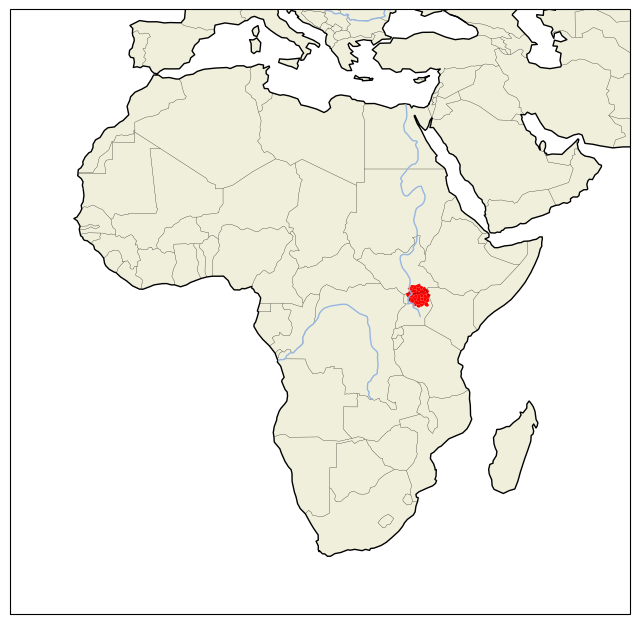

In [3]:
def get_ids_from_centroid(degree, centroid):
        neighbors = polygons.loc[centroid].neighbors
        if degree == 1:
            return [centroid]+neighbors
        else:
            for _ in range(degree-1):
                new_neighbors = []
                for neighbor in neighbors:
                    new_neighbors += polygons.loc[neighbor].neighbors
                neighbors = list(set(new_neighbors))
            return neighbors

centroid = 7311 #counts: 218 
cell_ids = get_ids_from_centroid(degree = 3, centroid = 7311)

#Plot subset (used in pipeline)
plot_cells(cell_ids, mesoscale, "battles", verbose=False)

In [4]:
#create avalanche (only create causla graph -> setup avalanche is commented out)
ava_1 = Avalanche(dt = dt, dx = dx, gridix=3, setup=True)

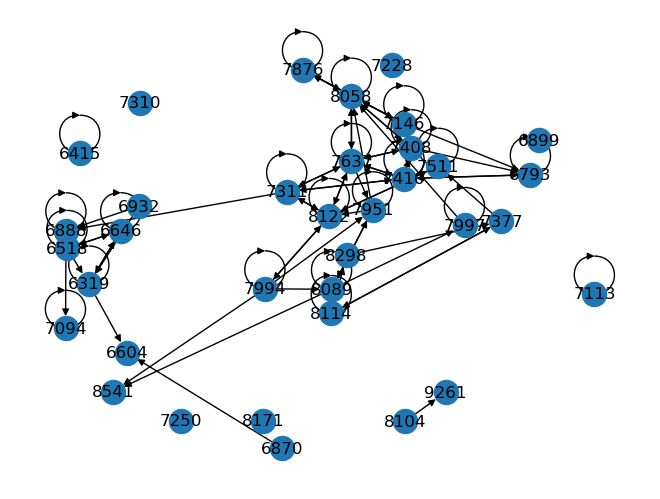

In [5]:
import networkx as nx
nx.draw(ava_1.causal_graph, with_labels=True)

In [6]:
print(ava_1.causal_graph)

CausalGraph with 35 nodes and 83 edges


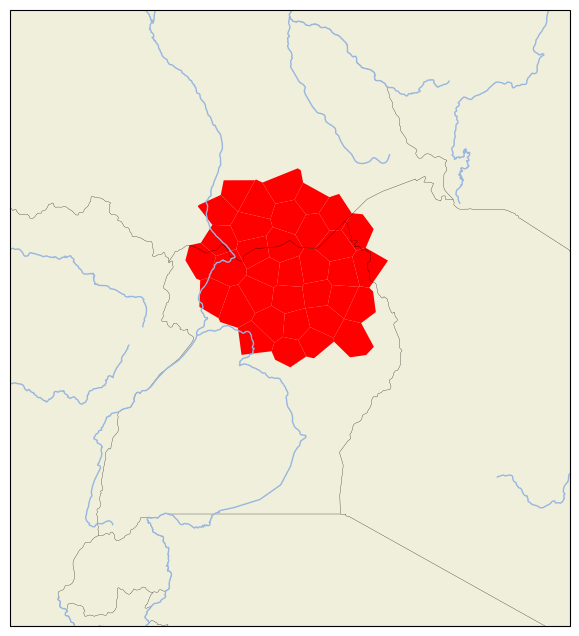

In [7]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection=ccrs.PlateCarree())

# Specify polygon and event here
for i, x in enumerate(cell_ids):
    poly = polygons.loc[[x]]
    poly.plot(ax=ax, color="red")
    
    # Get the centroid of the polygon
    centroid = poly.geometry.centroid.iloc[0]
    # Place the index of the polygon as text on the map

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linewidth=0.2)
ax.add_feature(cfeature.LAND)   
ax.add_feature(cfeature.RIVERS)

# Zoom in on Kenya, South Sudan, and Uganda

ax.set_extent([28, 38, -3, 8], crs=ccrs.PlateCarree())

plt.show()

# Algos

1. Works but is super inefficient. If both polygon id and neighbor exists in polygons (important to check because subset), pair gets added to pairs for two degrees. Neighbors of neighbors can touch initial polygon or can be connected to a first degree neighbor.

In [8]:
def polygon_pair_gen():
    pairs = []

    for polid, entry in neighbor_info_dataframe.iterrows():
        for neighbor in entry.neighbors:
            #current polygon has to be in time series, neighbor has to be in time series and polygon dataframe (as polygon dataframe is subset)
            if polid in time_series.columns and neighbor in neighbor_info_dataframe.index and neighbor in time_series.columns:
                pairs.append((polid, neighbor))
                
                for second_degree in neighbor_info_dataframe.loc[neighbor].neighbors:
                    if second_degree in time_series.columns and second_degree in neighbor_info_dataframe.index:
                        if second_degree != polid: #second degree can be initial index itself
                            pairs.append((polid, second_degree))
                    else:
                        next    
            else:
                next
                
    return set(pairs) #remove duplicates (second degree = first degree neighbour)

pair_poly_te = iter_polygon_pair(polygon_pair_gen(),
                                number_of_shuffles, 
                                time_series)
return pair_poly_te

NameError: name 'neighbor_info_dataframe' is not defined

In [ ]:
#refine
def polygon_pair_gen(degree = 1):
    if degree >= 3:
        raise ValueError("Degree has to be 1, 2 or 3")
    
    pairs = set() #remove duplicates (second degree = first degree neighbour)

    for polid, entry in neighbor_info_dataframe.iterrows():
        for first_degree in entry.neighbors:
            #current polygon has to be in time series, neighbor has to be in time series and polygon dataframe (as polygon dataframe is subset)
            if polid in time_series.columns and first_degree in neighbor_info_dataframe.index and first_degree in time_series.columns:
                pairs.add((polid, first_degree))
                
            if degree == 2: #if not return
                for second_degree in neighbor_info_dataframe.loc[neighbor].neighbors:
                    if second_degree in time_series.columns and second_degree in neighbor_info_dataframe.index:
                        if second_degree != polid: #second degree can be initial index itself
                            pairs.add((polid, second_degree))
                    
                    if degree == 3:
                        for third_degree in neighbor_info_dataframe.loc[second_degree].neighbors:
                            if third_degree in time_series.columns and third_degree in neighbor_info_dataframe.index:
                                if third_degree != polid:
                                    pairs.add((polid, third_degree))
                
    return pairs

pair_poly_te = iter_polygon_pair(polygon_pair_gen(),
                                number_of_shuffles, 
                                time_series)
return pair_poly_te

2. Only returns the tuples (and inverted tuples) starting from one central cell.

In [ ]:
# neighborhood of a cell with a certain degree
# returns a list of tuples of the form (cell1, cell2) where cell1 is the centroid and cell2 is a neighbor plus the inverse tuple

def get_tuples_from_centroid(polygons, count_ts, centroid, degree=1, verbose = False):
    neighbors = polygons.loc[centroid].neighbors
    # Check if neighbors are in count_ts columns
    neighbors = [n for n in neighbors if n in count_ts.columns]
    
    if degree == 1:
        tuples = [(centroid, n) for n in neighbors] + [(n, centroid) for n in neighbors]
    else:
        for i in range(degree-1):
            new_neighbors = []
            for neighbor in neighbors:
                new_neighbors += polygons.loc[neighbor].neighbors
            neighbors = list(set(new_neighbors))
            # Check if neighbors are in count_ts columns
            neighbors = [n for n in neighbors if n in count_ts.columns]
        tuples = [(centroid, n) for n in neighbors] + [(n, centroid) for n in neighbors]
    
    if verbose:
        return tuples, neighbors
    else:
        return tuples

3. Adjacency matrix

In [37]:
polygons.index.to_numpy()

array([    0,     1,     2, ..., 28563, 28565, 28586])

In [30]:
polygons

,index,neighbors,geometry
0,0,"[1, 2, 3, 5, 6, 15, 22]","POLYGON ((19.81208 24.13736, 19.79926 24.61359..."
1,1,"[0, 3, 6, 11, 13]","POLYGON ((20.79369 23.69985, 20.46114 23.60876..."
2,2,"[0, 5, 19, 22, 42, 55]","POLYGON ((19.33733 24.60151, 19.26730 25.01000..."
3,3,"[0, 1, 4, 7, 13, 15]","POLYGON ((19.93171 23.53836, 19.79783 23.78977..."
4,4,"[3, 7, 13, 18, 30, 37, 58]","POLYGON ((20.54628 23.06534, 20.50324 22.98831..."
...,...,...,...
28486,20337,"[28317, 28457, 28478, 28563, 28565, 28586]","POLYGON ((-19.12800 -36.33479, -18.79956 -36.4..."
28540,20338,"[27457, 27525, 28058, 28105, 28121]","POLYGON ((-18.50146 -34.49664, -18.43828 -34.5..."
28563,20339,"[28336, 28457, 28486, 28565]","POLYGON ((-18.39533 -37.25305, -18.70267 -37.2..."
28565,20340,"[28486, 28563, 28586]","POLYGON ((-19.32729 -36.72109, -18.99453 -37.0..."


In [4]:
import pandas as pd
import numpy as np
from scipy.sparse import lil_matrix, csr_matrix

# Create DataFrame and set cell_id as the index
df = polygons.copy()

# Number of polygons
n = len(df)

# Initialize an empty sparse adjacency matrix
adjacency_matrix = lil_matrix((n, n), dtype=int)

# Create a mapping from cell_id to matrix position
cell_id_to_pos = {cell_id: pos for pos, cell_id in enumerate(df.index)}

# Populate the sparse adjacency matrix based on the neighbors
for cell_id, neighbors in df['neighbors'].items():
    for neighbor in neighbors:
        if neighbor in cell_id_to_pos:
            adjacency_matrix[cell_id_to_pos[cell_id], cell_id_to_pos[neighbor]] = 1

# Convert the adjacency matrix to CSR format for efficient operations
adjacency_matrix = adjacency_matrix.tocsr()

# Square the sparse adjacency matrix to get second-degree neighbors
adjacency_matrix_squared = adjacency_matrix @ adjacency_matrix

# Convert the squared adjacency matrix to a DataFrame
adjacency_df_squared = pd.DataFrame(
    adjacency_matrix_squared.toarray(), index=df.index, columns=df.index
)

print("Adjacency Matrix (Sparse):")
print(adjacency_matrix.toarray())

print("\nSquared Adjacency Matrix (Second-degree neighbors):")
print(adjacency_df_squared)


Adjacency Matrix (Sparse):
[[0 1 1 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 1 0 1]
 [0 0 0 ... 0 1 0]]

Squared Adjacency Matrix (Second-degree neighbors):
       0      1      2      3      4      5      6      7      8      9      \
0          7      2      2      2      1      2      2      2      0      0   
1          2      5      1      2      2      2      2      1      2      0   
2          2      1      6      1      0      2      2      0      0      0   
3          2      2      1      6      2      1      2      2      1      0   
4          1      2      0      2      7      0      0      2      1      0   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
28486      0      0      0      0      0      0      0      0      0      0   
28540      0      0      0      0      0      0      0      0      0      0   
28563      0      0      0      0      0      0      0      0      0      0   
28565     

In [6]:
df['neighbors'].items()

TypeError: 'zip' object is not subscriptable